In [1]:
import os
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Dataset, DataLoader



# # Patch Extraction of HR and LR 

In [ ]:
import os
import cv2
import math
import numpy as np
from PIL import Image

# --- CONFIG ---
input_dir = r"C:\Users\user\Desktop\Vardhan\CVIP\Project\Dataset\train\part1\images"
output_hr_dir = r"C:\Users\user\Desktop\Vardhan\CVIP\Project\Dataset\train\part1\train_patches_edited\HR"
output_lr_dir =r"C:\Users\user\Desktop\Vardhan\CVIP\Project\Dataset\train\part1\train_patches_edited\LR"
patch_size = 256
stride = 128
scale = 4  # Downscale factor (HR:256 → LR:64)

os.makedirs(output_hr_dir, exist_ok=True)
os.makedirs(output_lr_dir, exist_ok=True)

# --- Padding Function ---
def pad_image_to_fit_patch(img, patch_size, stride):
    h, w, _ = img.shape
    pad_h = (math.ceil((h - patch_size) / stride) + 1) * stride + patch_size - h
    pad_w = (math.ceil((w - patch_size) / stride) + 1) * stride + patch_size - w
    padded_img = cv2.copyMakeBorder(img, 0, pad_h, 0, pad_w, borderType=cv2.BORDER_REFLECT_101)
    return padded_img

# --- Main Patch Extraction Function ---
def extract_paired_patches(image_path, image_name):
    img_hr = Image.open(image_path).convert("RGB")
    img_hr = np.array(img_hr)
    
    img_hr = pad_image_to_fit_patch(img_hr, patch_size, stride)
    h, w, _ = img_hr.shape

    img_lr = cv2.resize(img_hr, (w // scale, h // scale), interpolation=cv2.INTER_CUBIC)

    patch_id = 0
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            hr_patch = img_hr[y:y + patch_size, x:x + patch_size]

            x_lr = x // scale
            y_lr = y // scale
            lr_patch = img_lr[y_lr:y_lr + patch_size // scale, x_lr:x_lr + patch_size // scale]

            hr_patch_img = Image.fromarray(hr_patch)
            hr_patch_filename = f"{os.path.splitext(image_name)[0]}patch{patch_id:04d}.png"
            hr_patch_img.save(os.path.join(output_hr_dir, hr_patch_filename))

            lr_patch_img = Image.fromarray(lr_patch)
            lr_patch_img.save(os.path.join(output_lr_dir, hr_patch_filename))

            patch_id += 1

image_files = [f for f in os.listdir(input_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

print(f"\n Found {len(image_files)} images. Starting patch extraction...\n")

for idx, image_name in enumerate(image_files):
    image_path = os.path.join(input_dir, image_name)
    print(f"[{idx+1}/{len(image_files)}] Processing {image_name}...")
    extract_paired_patches(image_path, image_name)

print("\n Done! HR and LR patches saved to:")
print(f"    HR → {output_hr_dir}")
print(f"    LR → {output_lr_dir}")

In [12]:
import os

hr_dir = "/kaggle/input/train-patches-edited/train_patches_edited/HR"
lr_dir = "/kaggle/input/train-patches-edited/train_patches_edited/LR"

num_hr_patches = len([f for f in os.listdir(hr_dir) if f.endswith('.png')])
num_lr_patches = len([f for f in os.listdir(lr_dir) if f.endswith('.png')])

print(f" Total HR patches: {num_hr_patches}")
print(f" Total LR patches: {num_lr_patches}")


 Total HR patches: 83173
 Total LR patches: 83173


# Random Patches

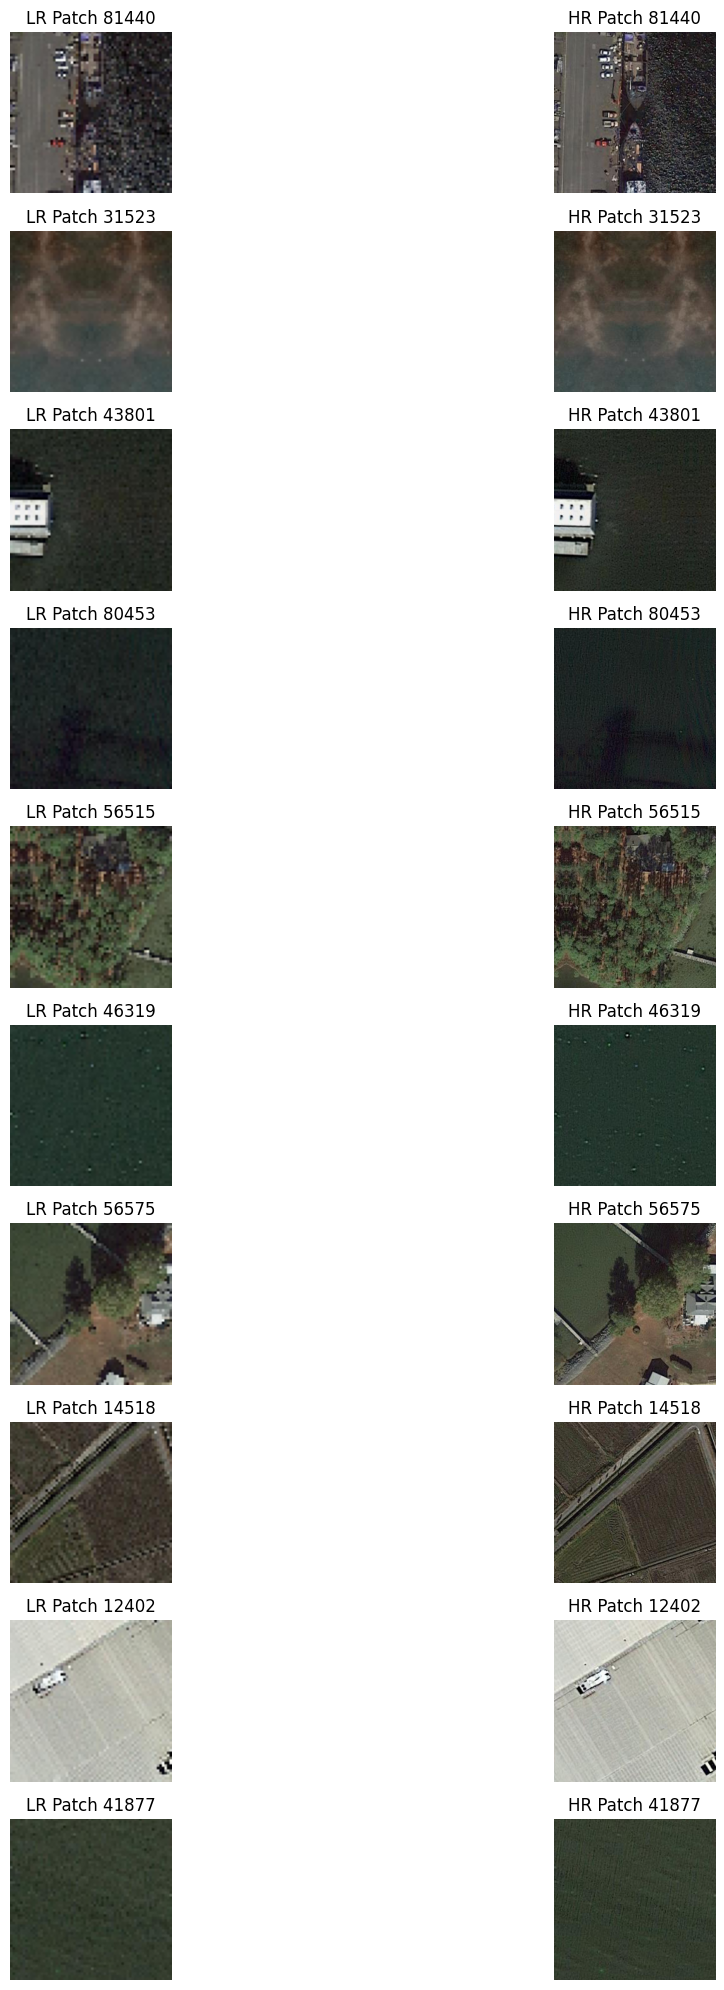

In [23]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Directories
hr_dir = "/kaggle/input/train-patches-edited/train_patches_edited/HR"
lr_dir = "/kaggle/input/train-patches-edited/train_patches_edited/LR"

lr_files = sorted([f for f in os.listdir(lr_dir) if f.endswith('.png')])
hr_files = sorted([f for f in os.listdir(hr_dir) if f.endswith('.png')])

num_samples = 10
indices = random.sample(range(len(lr_files)), num_samples)

plt.figure(figsize=(15, 20))

for i, idx in enumerate(indices):
    lr_path = os.path.join(lr_dir, lr_files[idx])
    hr_path = os.path.join(hr_dir, hr_files[idx])
    
    lr_img = Image.open(lr_path)
    hr_img = Image.open(hr_path)
    
    # LR image
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.imshow(lr_img)
    plt.title(f"LR Patch {idx}")
    plt.axis('off')

    # HR image
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.imshow(hr_img)
    plt.title(f"HR Patch {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
import os
import cv2
import numpy as np
from PIL import Image

import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


# Data Loading

In [14]:
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_images = sorted([os.path.join(lr_dir, x) for x in os.listdir(lr_dir) if x.endswith('.png')])
        self.hr_images = sorted([os.path.join(hr_dir, x) for x in os.listdir(hr_dir) if x.endswith('.png')])
        self.transform = transform

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr = Image.open(self.lr_images[idx]).convert("RGB")
        hr = Image.open(self.hr_images[idx]).convert("RGB")

        if self.transform:
            lr = self.transform(lr)
            hr = self.transform(hr)

        return lr, hr

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = SRDataset(lr_dir, hr_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)


# Generator Network

In [15]:
import torch
import torch.nn as nn

# Residual Block used in Generator
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

# Generator Network
class Generator(nn.Module):
    def __init__(self, scale_factor=4, num_residual_blocks=16):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )

        # Residual blocks
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_residual_blocks)]
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )

        # Upsampling layers (2x → 4x)
        upsample_blocks = []
        for _ in range(int(scale_factor / 2)):
            upsample_blocks += [
                nn.Conv2d(64, 256, kernel_size=3, padding=1),
                nn.PixelShuffle(2),
                nn.PReLU()
            ]
        self.upsampling = nn.Sequential(*upsample_blocks)

        # Final output layer
        self.final = nn.Conv2d(64, 3, kernel_size=9, padding=4)

    def forward(self, x):
        initial = self.initial(x)
        res = self.res_blocks(initial)
        bottleneck = self.bottleneck(res)
        upsampled = self.upsampling(initial + bottleneck)
        return self.final(upsampled)




# Discriminator Network

In [25]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_shape=(3, 256, 256)):
        super(Discriminator, self).__init__()

        # Reusable block: Conv2d → (BN) → LeakyReLU
        def discriminator_block(in_filters, out_filters, stride, use_bn=True):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=stride, padding=1)]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        
        self.model = nn.Sequential(
            *discriminator_block(3, 64, stride=1, use_bn=False),   # Block 1: no BN
            *discriminator_block(64, 64, stride=2),
            *discriminator_block(64, 128, stride=1),
            *discriminator_block(128, 128, stride=2),
            *discriminator_block(128, 256, stride=1),
            *discriminator_block(256, 256, stride=2),
            *discriminator_block(256, 512, stride=1),
            *discriminator_block(512, 512, stride=2),
            nn.AdaptiveAvgPool2d((6, 6))  # Fixed output for FC
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()  # Binary classification: Real (1) / Fake (0)
        )

    def forward(self, img):
        features = self.model(img)
        return self.classifier(features)


# Loss Functions

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure

# --- Content Loss (Pixel-wise MSE Loss) ---
mse_loss = nn.MSELoss()

# --- Adversarial Loss (Binary Cross-Entropy) ---
bce_loss = nn.BCELoss()

# --- Perceptual Loss using VGG19 weights from URL ---
class VGGFeatureExtractor(nn.Module):
    def __init__(self):
        super(VGGFeatureExtractor, self).__init__()
        vgg19 = models.vgg19()
        # Load pre-trained weights from official PyTorch model URL
        vgg19.load_state_dict(
            torch.hub.load_state_dict_from_url(
                "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth",
                progress=True
            )
        )
        self.feature_extractor = nn.Sequential(*list(vgg19.features)[:36])  # Up to relu_5_4
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, img):
        return self.feature_extractor(img)


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
discriminator = Discriminator().to(device)
vgg = VGGFeatureExtractor().to(device)


#optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.9, 0.999))

#optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.9, 0.999), weight_decay=1e-5)


In [28]:
from torchinfo import summary  # or from torchsummary import summary

summary(generator, input_size=(1, 3, 64, 64))




Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 256, 256]          --
├─Sequential: 1-1                        [1, 64, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 64, 64, 64]           15,616
│    └─PReLU: 2-2                        [1, 64, 64, 64]           1
├─Sequential: 1-2                        [1, 64, 64, 64]           --
│    └─ResidualBlock: 2-3                [1, 64, 64, 64]           --
│    │    └─Sequential: 3-1              [1, 64, 64, 64]           74,113
│    └─ResidualBlock: 2-4                [1, 64, 64, 64]           --
│    │    └─Sequential: 3-2              [1, 64, 64, 64]           74,113
│    └─ResidualBlock: 2-5                [1, 64, 64, 64]           --
│    │    └─Sequential: 3-3              [1, 64, 64, 64]           74,113
│    └─ResidualBlock: 2-6                [1, 64, 64, 64]           --
│    │    └─Sequential: 3-4              [1, 64, 64, 64]           74,

In [29]:
summary(discriminator, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 512, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 256, 256]         1,792
│    └─LeakyReLU: 2-2                    [1, 64, 256, 256]         --
│    └─Conv2d: 2-3                       [1, 64, 128, 128]         36,928
│    └─BatchNorm2d: 2-4                  [1, 64, 128, 128]         128
│    └─LeakyReLU: 2-5                    [1, 64, 128, 128]         --
│    └─Conv2d: 2-6                       [1, 128, 128, 128]        73,856
│    └─BatchNorm2d: 2-7                  [1, 128, 128, 128]        256
│    └─LeakyReLU: 2-8                    [1, 128, 128, 128]        --
│    └─Conv2d: 2-9                       [1, 128, 64, 64]          147,584
│    └─BatchNorm2d: 2-10                 [1, 128, 64, 64]          256
│    └─LeakyReLU: 2-11                   [1, 128, 64, 64]         

In [13]:
generator.load_state_dict(torch.load("/kaggle/input/epoch-48/srgan_generator_epoch_48.pth"))
discriminator.load_state_dict(torch.load("/kaggle/input/epoch-48/srgan_discriminator_epoch_48.pth"))

generator = generator.to(device)
discriminator = discriminator.to(device)


<ipython-input-13-c1a5dbbf9b08>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("/kaggle/input/epoch-48/srgan_generator_epoch_48.pth"))

# Training

In [ ]:
import time
import csv


start_epoch = 1
num_epochs = 50
lambda_content = 1.0       
lambda_perceptual = 1.0   
lambda_adv = 5e-4          

# --- Freeze VGG ---
for param in vgg.parameters():
    param.requires_grad = False

# --- Optimizers ---
optimizer_G = torch.optim.Adam(generator.parameters(), lr=5e-5, betas=(0.9, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=5e-6, betas=(0.9, 0.999), weight_decay=1e-6)

# --- LR Scheduler for Generator ---
scheduler_G = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, mode='max', factor=0.5, patience=2, verbose=True, min_lr=1e-6 )

# --- Metrics ---
psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# --- Training Loop ---
for epoch in range(start_epoch, num_epochs + 1):
    start_time = time.time()

    generator.train()
    discriminator.train()

    total_g_loss = 0
    total_d_loss = 0

    for i, (lr, hr) in enumerate(dataloader):
        lr = lr.to(device)
        hr = hr.to(device)

        optimizer_D.zero_grad()
        real_labels = torch.ones((lr.size(0), 1), dtype=torch.float32).to(device)
        fake_labels = torch.zeros((lr.size(0), 1), dtype=torch.float32).to(device)

        sr = generator(lr)

        real_out = discriminator(hr.detach())
        fake_out = discriminator(sr.detach())

        d_loss_real = bce_loss(real_out, real_labels)
        d_loss_fake = bce_loss(fake_out, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        pred_fake = discriminator(sr)
        adv_loss = bce_loss(pred_fake, real_labels)

        content_loss = mse_loss(sr, hr)
        sr_vgg = vgg(sr)
        hr_vgg = vgg(hr)
        perceptual_loss = mse_loss(sr_vgg, hr_vgg)

        g_loss = (lambda_content * content_loss) + \
                 (lambda_perceptual * perceptual_loss) + \
                 (lambda_adv * adv_loss)

        g_loss.backward()
        optimizer_G.step()

        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}] "
                  f"G Loss: {g_loss.item():.4f} | D Loss: {d_loss.item():.4f}")

    # --- Evaluate ---
    generator.eval()
    with torch.no_grad():
        total_psnr = 0.0
        total_ssim = 0.0
        for lr, hr in dataloader:
            lr = lr.to(device)
            hr = hr.to(device)

            sr = generator(lr)
            sr = torch.clamp(sr, 0.0, 1.0)

            total_psnr += psnr_metric(sr, hr).item()
            total_ssim += ssim_metric(sr, hr).item()

        avg_psnr = total_psnr / len(dataloader)
        avg_ssim = total_ssim / len(dataloader)

    print(f"PSNR: {avg_psnr:.2f} dB | SSIM: {avg_ssim:.4f}")

    # --- Step Scheduler ---
    scheduler_G.step(avg_psnr)

    # --- Save Models ---
    gen_path = f"/kaggle/working/srgan_generator_epoch_{epoch}.pth"
    disc_path = f"/kaggle/working/srgan_discriminator_epoch_{epoch}.pth"
    torch.save(generator.state_dict(), gen_path)
    torch.save(discriminator.state_dict(), disc_path)
    print(f"Model saved at epoch {epoch}")

    zip_path = f"/kaggle/working/srgan_models_epoch_{epoch}.zip"
    os.system(f"zip -j {zip_path} {gen_path} {disc_path}")
    print(f"Zipped models saved to: {zip_path}")

    # --- Time ---
    end_time = time.time()
    epoch_time = (end_time - start_time) / 60
    print(f"Epoch {epoch} completed | Avg G Loss: {total_g_loss/len(dataloader):.4f} | "
          f"Avg D Loss: {total_d_loss/len(dataloader):.4f} | Time: {epoch_time:.2f} mins")


## Loading the Checkpoints to continue the training

In [ ]:
generator.load_state_dict(torch.load("/kaggle/working/srgan_generator_epoch_45.pth"))
discriminator.load_state_dict(torch.load("/kaggle/working/srgan_discriminator_epoch_45.pth"))

generator = generator.to(device)
discriminator = discriminator.to(device)


In [13]:
import time
import csv


start_epoch = 46
num_epochs = 47 

lambda_content = 1.0       
lambda_perceptual = 1.0    
lambda_adv = 5e-4         
# --- Freeze VGG ---
for param in vgg.parameters():
    param.requires_grad = False

# --- Optimizers (fine-tuning mode) ---
optimizer_G = torch.optim.Adam(generator.parameters(), lr=5e-5, betas=(0.9, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=5e-6, betas=(0.9, 0.999), weight_decay=1e-6)

# --- LR Scheduler for Generator ---
scheduler_G = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, mode='max', factor=0.5, patience=2, verbose=True, min_lr=1e-6 )

# --- Metrics ---
psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)


# --- Training Loop ---
for epoch in range(start_epoch, num_epochs + 1):
    start_time = time.time()

    generator.train()
    discriminator.train()

    total_g_loss = 0
    total_d_loss = 0

    for i, (lr, hr) in enumerate(dataloader):
        lr = lr.to(device)
        hr = hr.to(device)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        real_labels = torch.ones((lr.size(0), 1), dtype=torch.float32).to(device)
        fake_labels = torch.zeros((lr.size(0), 1), dtype=torch.float32).to(device)

        sr = generator(lr)

        real_out = discriminator(hr.detach())
        fake_out = discriminator(sr.detach())

        d_loss_real = bce_loss(real_out, real_labels)
        d_loss_fake = bce_loss(fake_out, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2

        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        optimizer_G.zero_grad()

        pred_fake = discriminator(sr)
        adv_loss = bce_loss(pred_fake, real_labels)

        content_loss = mse_loss(sr, hr)

        sr_vgg = vgg(sr)
        hr_vgg = vgg(hr)
        perceptual_loss = mse_loss(sr_vgg, hr_vgg)

        g_loss = (lambda_content * content_loss) + \
                 (lambda_perceptual * perceptual_loss) + \
                 (lambda_adv * adv_loss)

        g_loss.backward()
        optimizer_G.step()

        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}] "
                  f"G Loss: {g_loss.item():.4f} | D Loss: {d_loss.item():.4f}")

    # --- Evaluate ---
    generator.eval()
    with torch.no_grad():
        total_psnr = 0.0
        total_ssim = 0.0
        for lr, hr in dataloader:
            lr = lr.to(device)
            hr = hr.to(device)

            sr = generator(lr)
            sr = torch.clamp(sr, 0.0, 1.0)

            total_psnr += psnr_metric(sr, hr).item()
            total_ssim += ssim_metric(sr, hr).item()

        avg_psnr = total_psnr / len(dataloader)
        avg_ssim = total_ssim / len(dataloader)

    print(f"PSNR: {avg_psnr:.2f} dB | SSIM: {avg_ssim:.4f}")

    # --- Step Scheduler ---
    scheduler_G.step(avg_psnr)

    # --- Save Models ---
    gen_path = f"/kaggle/working/srgan_generator_epoch_{epoch}.pth"
    disc_path = f"/kaggle/working/srgan_discriminator_epoch_{epoch}.pth"
    torch.save(generator.state_dict(), gen_path)
    torch.save(discriminator.state_dict(), disc_path)
    print(f"Model saved at epoch {epoch}")

    zip_path = f"/kaggle/working/srgan_models_epoch_{epoch}.zip"
    os.system(f"zip -j {zip_path} {gen_path} {disc_path}")
    print(f"Zipped models saved to: {zip_path}")

    # --- Time ---
    end_time = time.time()
    epoch_time = (end_time - start_time) / 60
    print(f"Epoch {epoch} completed | Avg G Loss: {total_g_loss/len(dataloader):.4f} | "
          f"Avg D Loss: {total_d_loss/len(dataloader):.4f} | Time: {epoch_time:.2f} mins")


Epoch [46/47] Batch [0] G Loss: 0.0351 | D Loss: 0.2819
Epoch [46/47] Batch [100] G Loss: 0.0395 | D Loss: 0.0208
Epoch [46/47] Batch [200] G Loss: 0.0303 | D Loss: 0.0009
Epoch [46/47] Batch [300] G Loss: 0.0345 | D Loss: 0.0013
Epoch [46/47] Batch [400] G Loss: 0.0384 | D Loss: 0.0219
Epoch [46/47] Batch [500] G Loss: 0.0501 | D Loss: 0.0033
Epoch [46/47] Batch [600] G Loss: 0.0344 | D Loss: 0.0079
Epoch [46/47] Batch [700] G Loss: 0.0365 | D Loss: 0.0077
Epoch [46/47] Batch [800] G Loss: 0.0309 | D Loss: 0.1414
Epoch [46/47] Batch [900] G Loss: 0.0409 | D Loss: 0.0030
Epoch [46/47] Batch [1000] G Loss: 0.0388 | D Loss: 0.0124
Epoch [46/47] Batch [1100] G Loss: 0.0318 | D Loss: 0.0612
Epoch [46/47] Batch [1200] G Loss: 0.0355 | D Loss: 0.0077
Epoch [46/47] Batch [1300] G Loss: 0.0372 | D Loss: 0.0216
Epoch [46/47] Batch [1400] G Loss: 0.0361 | D Loss: 0.0178
Epoch [46/47] Batch [1500] G Loss: 0.0371 | D Loss: 0.0504
Epoch [46/47] Batch [1600] G Loss: 0.0452 | D Loss: 0.0292
Epoch [46

In [15]:
import time
import csv


start_epoch = 48
num_epochs = 48 

lambda_content = 1.0       
lambda_perceptual = 1.0    
lambda_adv = 5e-4          

# --- Freeze VGG ---
for param in vgg.parameters():
    param.requires_grad = False

# --- Optimizers---
optimizer_G = torch.optim.Adam(generator.parameters(), lr=5e-5, betas=(0.9, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=5e-6, betas=(0.9, 0.999), weight_decay=1e-6)

# --- LR Scheduler for Generator ---
scheduler_G = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, mode='max', factor=0.5, patience=2, verbose=True, min_lr=1e-6 )

# --- Metrics ---
psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# --- Training Loop ---
for epoch in range(start_epoch, num_epochs + 1):
    start_time = time.time()

    generator.train()
    discriminator.train()

    total_g_loss = 0
    total_d_loss = 0

    for i, (lr, hr) in enumerate(dataloader):
        lr = lr.to(device)
        hr = hr.to(device)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        real_labels = torch.ones((lr.size(0), 1), dtype=torch.float32).to(device)
        fake_labels = torch.zeros((lr.size(0), 1), dtype=torch.float32).to(device)

        sr = generator(lr)

        real_out = discriminator(hr.detach())
        fake_out = discriminator(sr.detach())

        d_loss_real = bce_loss(real_out, real_labels)
        d_loss_fake = bce_loss(fake_out, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2

        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        optimizer_G.zero_grad()

        pred_fake = discriminator(sr)
        adv_loss = bce_loss(pred_fake, real_labels)

        content_loss = mse_loss(sr, hr)

        sr_vgg = vgg(sr)
        hr_vgg = vgg(hr)
        perceptual_loss = mse_loss(sr_vgg, hr_vgg)

        g_loss = (lambda_content * content_loss) + \
                 (lambda_perceptual * perceptual_loss) + \
                 (lambda_adv * adv_loss)

        g_loss.backward()
        optimizer_G.step()

        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}] "
                  f"G Loss: {g_loss.item():.4f} | D Loss: {d_loss.item():.4f}")

    # --- Evaluate ---
    generator.eval()
    with torch.no_grad():
        total_psnr = 0.0
        total_ssim = 0.0
        for lr, hr in dataloader:
            lr = lr.to(device)
            hr = hr.to(device)

            sr = generator(lr)
            sr = torch.clamp(sr, 0.0, 1.0)

            total_psnr += psnr_metric(sr, hr).item()
            total_ssim += ssim_metric(sr, hr).item()

        avg_psnr = total_psnr / len(dataloader)
        avg_ssim = total_ssim / len(dataloader)

    print(f"PSNR: {avg_psnr:.2f} dB | SSIM: {avg_ssim:.4f}")

    # --- Step Scheduler ---
    scheduler_G.step(avg_psnr)

    # --- Save Models ---
    gen_path = f"/kaggle/working/srgan_generator_epoch_{epoch}.pth"
    disc_path = f"/kaggle/working/srgan_discriminator_epoch_{epoch}.pth"
    torch.save(generator.state_dict(), gen_path)
    torch.save(discriminator.state_dict(), disc_path)
    print(f"Model saved at epoch {epoch}")

    zip_path = f"/kaggle/working/srgan_models_epoch_{epoch}.zip"
    os.system(f"zip -j {zip_path} {gen_path} {disc_path}")
    print(f"Zipped models saved to: {zip_path}")

    # --- Time ---
    end_time = time.time()
    epoch_time = (end_time - start_time) / 60
    print(f"Epoch {epoch} completed | Avg G Loss: {total_g_loss/len(dataloader):.4f} | "
          f"Avg D Loss: {total_d_loss/len(dataloader):.4f} | Time: {epoch_time:.2f} mins")

   

Epoch [48/48] Batch [0] G Loss: 0.0329 | D Loss: 0.0046
Epoch [48/48] Batch [100] G Loss: 0.0424 | D Loss: 0.0048
Epoch [48/48] Batch [200] G Loss: 0.0392 | D Loss: 0.9692
Epoch [48/48] Batch [300] G Loss: 0.0294 | D Loss: 0.0101
Epoch [48/48] Batch [400] G Loss: 0.0357 | D Loss: 0.0123
Epoch [48/48] Batch [500] G Loss: 0.0471 | D Loss: 0.0095
Epoch [48/48] Batch [600] G Loss: 0.0299 | D Loss: 0.1037
Epoch [48/48] Batch [700] G Loss: 0.0313 | D Loss: 0.0049
Epoch [48/48] Batch [800] G Loss: 0.0499 | D Loss: 0.0051
Epoch [48/48] Batch [900] G Loss: 0.0307 | D Loss: 0.0702
Epoch [48/48] Batch [1000] G Loss: 0.0398 | D Loss: 0.0007
Epoch [48/48] Batch [1100] G Loss: 0.0368 | D Loss: 0.0870
Epoch [48/48] Batch [1200] G Loss: 0.0423 | D Loss: 0.0103
Epoch [48/48] Batch [1300] G Loss: 0.0366 | D Loss: 0.0363
Epoch [48/48] Batch [1400] G Loss: 0.0282 | D Loss: 0.0090
Epoch [48/48] Batch [1500] G Loss: 0.0414 | D Loss: 0.0417
Epoch [48/48] Batch [1600] G Loss: 0.0325 | D Loss: 0.0068
Epoch [48

In [14]:
import time
import csv


start_epoch = 49
num_epochs = 50 

lambda_content = 1.0       
lambda_perceptual = 1.0    
lambda_adv = 5e-4          
# --- Freeze VGG ---
for param in vgg.parameters():
    param.requires_grad = False

# --- Optimizers (fine-tuning mode) ---
optimizer_G = torch.optim.Adam(generator.parameters(), lr=5e-5, betas=(0.9, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=5e-6, betas=(0.9, 0.999), weight_decay=1e-6)

# --- LR Scheduler for Generator ---
scheduler_G = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, mode='max', factor=0.5, patience=2, verbose=True, min_lr=1e-6 )

# --- Metrics ---
psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)


# --- Training Loop ---
for epoch in range(start_epoch, num_epochs + 1):
    start_time = time.time()

    generator.train()
    discriminator.train()

    total_g_loss = 0
    total_d_loss = 0

    for i, (lr, hr) in enumerate(dataloader):
        lr = lr.to(device)
        hr = hr.to(device)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        real_labels = torch.ones((lr.size(0), 1), dtype=torch.float32).to(device)
        fake_labels = torch.zeros((lr.size(0), 1), dtype=torch.float32).to(device)

        sr = generator(lr)

        real_out = discriminator(hr.detach())
        fake_out = discriminator(sr.detach())

        d_loss_real = bce_loss(real_out, real_labels)
        d_loss_fake = bce_loss(fake_out, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2

        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        optimizer_G.zero_grad()

        pred_fake = discriminator(sr)
        adv_loss = bce_loss(pred_fake, real_labels)

        content_loss = mse_loss(sr, hr)

        sr_vgg = vgg(sr)
        hr_vgg = vgg(hr)
        perceptual_loss = mse_loss(sr_vgg, hr_vgg)

        g_loss = (lambda_content * content_loss) + \
                 (lambda_perceptual * perceptual_loss) + \
                 (lambda_adv * adv_loss)

        g_loss.backward()
        optimizer_G.step()

        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}] "
                  f"G Loss: {g_loss.item():.4f} | D Loss: {d_loss.item():.4f}")

    # --- Evaluate ---
    generator.eval()
    with torch.no_grad():
        total_psnr = 0.0
        total_ssim = 0.0
        for lr, hr in dataloader:
            lr = lr.to(device)
            hr = hr.to(device)

            sr = generator(lr)
            sr = torch.clamp(sr, 0.0, 1.0)

            total_psnr += psnr_metric(sr, hr).item()
            total_ssim += ssim_metric(sr, hr).item()

        avg_psnr = total_psnr / len(dataloader)
        avg_ssim = total_ssim / len(dataloader)

    print(f"PSNR: {avg_psnr:.2f} dB | SSIM: {avg_ssim:.4f}")

    # --- Step Scheduler ---
    scheduler_G.step(avg_psnr)

    # --- Save Models ---
    gen_path = f"/kaggle/working/srgan_generator_epoch_{epoch}.pth"
    disc_path = f"/kaggle/working/srgan_discriminator_epoch_{epoch}.pth"
    torch.save(generator.state_dict(), gen_path)
    torch.save(discriminator.state_dict(), disc_path)
    print(f"Model saved at epoch {epoch}")

    zip_path = f"/kaggle/working/srgan_models_epoch_{epoch}.zip"
    os.system(f"zip -j {zip_path} {gen_path} {disc_path}")
    print(f"Zipped models saved to: {zip_path}")

    # --- Time ---
    end_time = time.time()
    epoch_time = (end_time - start_time) / 60
    print(f"Epoch {epoch} completed | Avg G Loss: {total_g_loss/len(dataloader):.4f} | "
          f"Avg D Loss: {total_d_loss/len(dataloader):.4f} | Time: {epoch_time:.2f} mins")



Epoch [49/50] Batch [0] G Loss: 0.0420 | D Loss: 0.0134
Epoch [49/50] Batch [100] G Loss: 0.0348 | D Loss: 0.0045
Epoch [49/50] Batch [200] G Loss: 0.0374 | D Loss: 0.0070
Epoch [49/50] Batch [300] G Loss: 0.0350 | D Loss: 0.0056
Epoch [49/50] Batch [400] G Loss: 0.0336 | D Loss: 0.3285
Epoch [49/50] Batch [500] G Loss: 0.0342 | D Loss: 0.0380
Epoch [49/50] Batch [600] G Loss: 0.0378 | D Loss: 0.0043
Epoch [49/50] Batch [700] G Loss: 0.0416 | D Loss: 0.0108
Epoch [49/50] Batch [800] G Loss: 0.0360 | D Loss: 0.0698
Epoch [49/50] Batch [900] G Loss: 0.0406 | D Loss: 0.0599
Epoch [49/50] Batch [1000] G Loss: 0.0436 | D Loss: 0.0027
Epoch [49/50] Batch [1100] G Loss: 0.0378 | D Loss: 0.5811
Epoch [49/50] Batch [1200] G Loss: 0.0332 | D Loss: 0.0266
Epoch [49/50] Batch [1300] G Loss: 0.0415 | D Loss: 0.0121
Epoch [49/50] Batch [1400] G Loss: 0.0377 | D Loss: 0.0088
Epoch [49/50] Batch [1500] G Loss: 0.0305 | D Loss: 0.0238
Epoch [49/50] Batch [1600] G Loss: 0.0403 | D Loss: 0.0179
Epoch [49

# Fine Tuning

Epoch 1-20 

Lamba_Content=1.0

Lamba_Perceptual=1.0

Lamba_Adversial=1e-4

---
Epoch 21–24

Lambda_Content     = 1.0  

Lambda_Perceptual  = 0.8  

Lambda_Adversarial = 5e-4 

---
Epoch 25–27

Lambda_Content     = 1.0  

Lambda_Perceptual  = 1.0  

Lambda_Adversarial = 1e-4  

And scheduler_G = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, mode='max', factor=0.5, patience=2, verbose=True, min_lr=1e-6 )



---
Epoch 28–31

Lambda_Content     = 0.8  

Lambda_Perceptual  = 1.2  

Lambda_Adversarial = 5e-4  

---
Epoch 32–35

Lambda_Content     = 1.0  

Lambda_Perceptual  = 1.0  

Lambda_Adversarial = 5e-4  

---
Epoch 36

Lambda_Content     = 0.9  

Lambda_Perceptual  = 1.2  

Lambda_Adversarial = 5e-4  

---
Epoch 37–39

Lambda_Content     = 1.0  

Lambda_Perceptual  = 1.0  

Lambda_Adversarial = 5e-4  

---
Epoch 40–45

Lambda_Content     = 1.0  

Lambda_Perceptual  = 1.0  

Lambda_Adversarial = 4e-4 

---
Epoch 46-50

Lambda_Content     = 1.0  

Lambda_Perceptual  = 1.0  

Lambda_Adversarial = 5e-4